In [75]:
import pickle
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS

In [ ]:
# Set residuals file input name, tsv format
residuals_file = "rawData/batch/example.tsv"

In [ ]:
gene_expr_raw = pd.read_table(residuals_file)
gene_expr = gene_expr_raw.T
gene_expr

In [ ]:
ge_centered = (gene_expr - gene_expr.mean()) / np.sqrt(gene_expr.var())

# Fit a covariance matrix to the centered and scaled gene expression data
# OAS shrinkage estimator: https://www.cs.huji.ac.il/~amiw/chen_tsp_2010.pdf
# https://scikit-learn.org/stable/auto_examples/covariance/plot_lw_vs_oas.html
oa = OAS(store_precision=True, assume_centered=True)
gene_expr_OAS_corr = oa.fit(ge_centered)
s_cov = gene_expr_OAS_corr.covariance_
n_genes = s_cov.shape[1]
n_genes

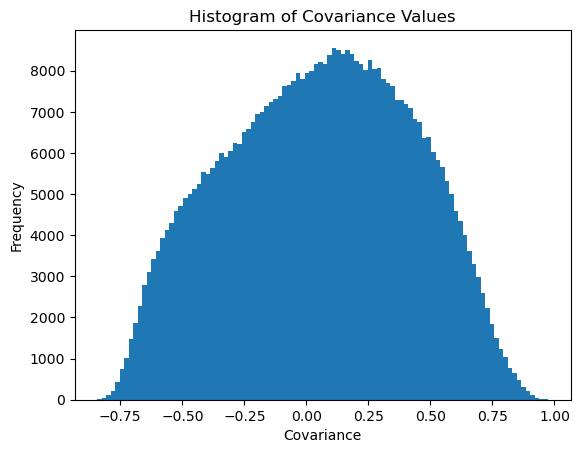

In [ ]:
# Set scov diagonal to zero
np.fill_diagonal(s_cov, 0)
s_cov

# Set upper triangle to zero
s_cov = np.triu(s_cov, k=1)
s_cov

# Plot histogram of s_cov   
import matplotlib.pyplot as plt
plt.hist(s_cov[s_cov != 0], bins=100)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of Correlation Values")
plt.show()  

In [ ]:
gfull = Graph(sp.sparse.lil_matrix(s_cov), directed=False)

cutOff = 0.5

sign = gfull.new_ep("bool", True)
sign.a = np.array(np.abs(gfull.ep.weight.a) > cutOff)

g = GraphView(gfull, efilt=sign)

# Keeping largest component
comp, hist = label_components(g)
main_component = g.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
g.vertex_properties["main_component"] = main_component
g.set_vertex_filter(main_component)


# Graph density
density = g.num_edges() / ((n_genes * n_genes - n_genes) / 2 )
print(f"Graph density: {density:.4f}")

Graph density: 0.2133


In [116]:
g

<GraphView object, undirected, with 1000 vertices and 106524 edges, 1 internal vertex property, 1 internal edge property, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7f29b8a439b0, at 0x7f28cb1b1d00>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7f29b8a439b0, at 0x7f28cb1b3530>, at 0x7f29b8a439b0>

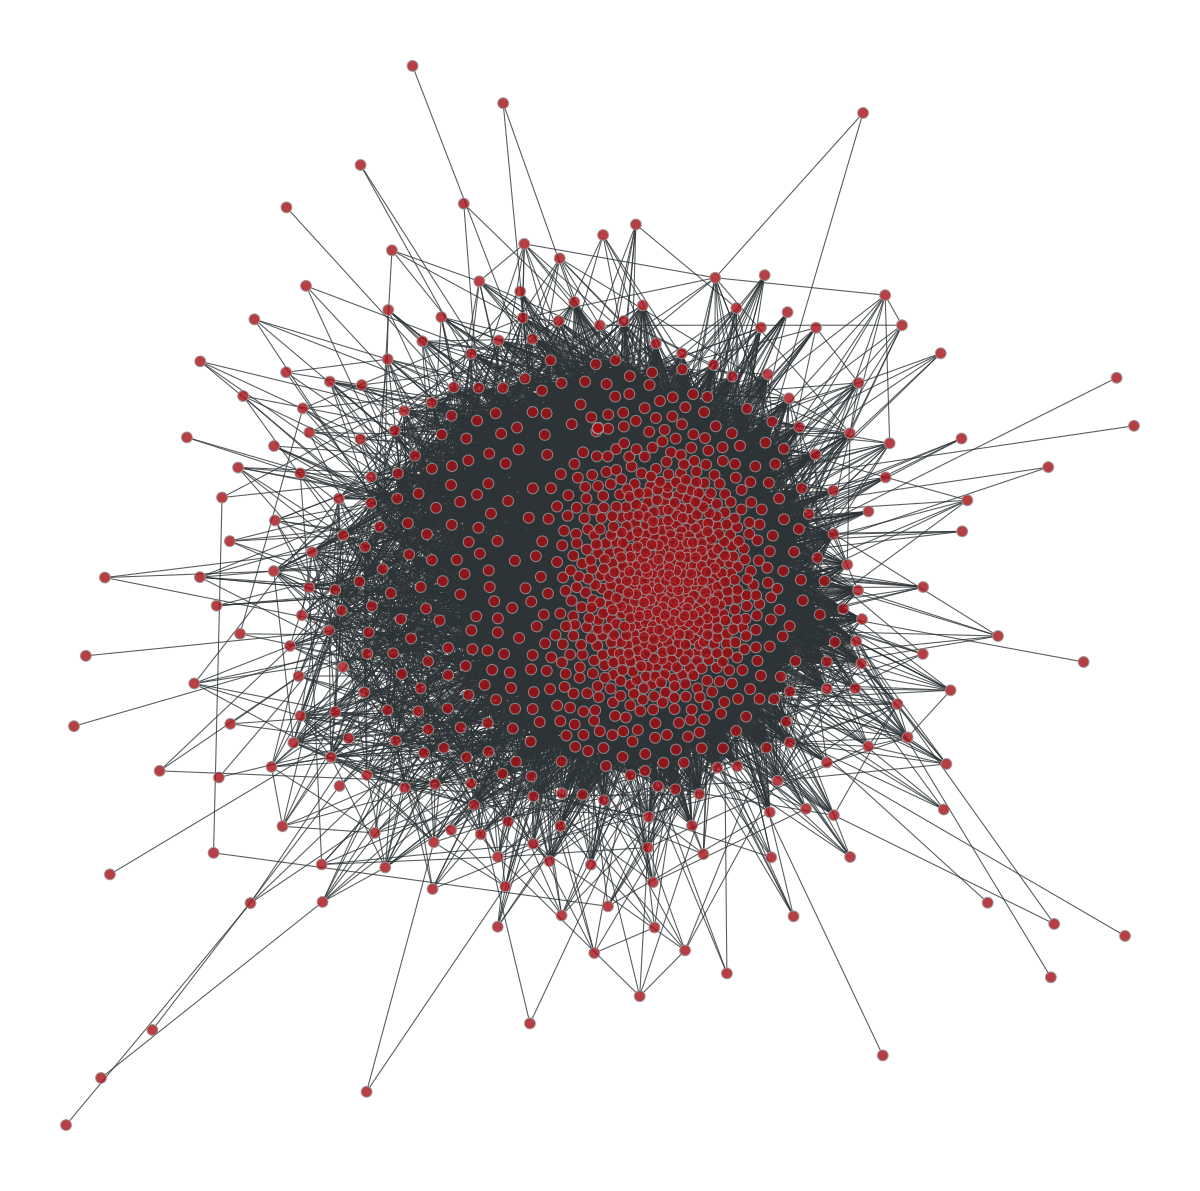

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f29b8a439b0, at 0x7f29c0eed400>

In [117]:
graph_draw(g)

In [118]:
state = minimize_nested_blockmodel_dl(g, 
                                      state_args=dict(recs=[g.ep.weight],
                                                        rec_types=["real-normal"]))

In [119]:
S1 = state.entropy()
mcmc_anneal(state, beta_range=(1, 10), niter=1000,
            mcmc_equilibrate_args=dict(force_niter=10), verbose=False)
S2 = state.entropy()
print("Improvement from annealing: " + str(S2 - S1))

Improvement from annealing: -3350.02172369811


In [ ]:
S1 = state.entropy()
mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10), verbose=False)
S2 = state.entropy()
print("Improvement from equilibration: " + str(S2 - S1))

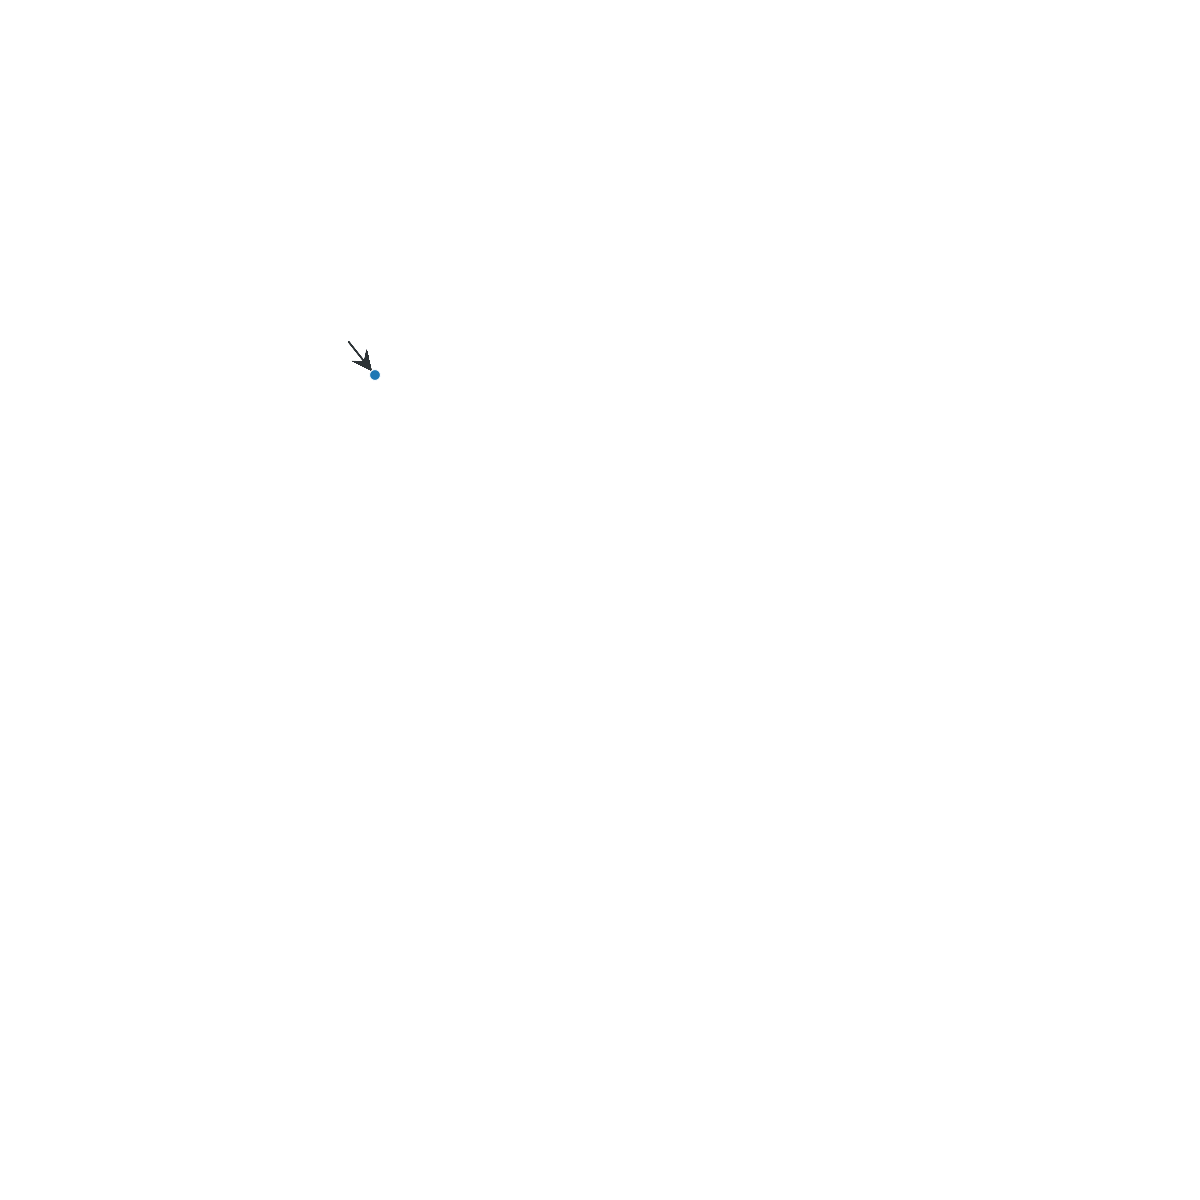

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f29c10509b0, at 0x7f29c103b7d0>

In [91]:
bstate = state.levels[0]
pos = sfdp_layout(state.get_bstack()[0], groups=bstate.get_blocks(), gamma=.02)
bstate.draw(pos=pos, vertex_color="white", edge_gradient=[],
            edge_pen_width=prop_to_size(g.ep.weight, mi=-4, ma=4, power=2, log=False))

In [ ]:
state.draw()

<GraphView object, undirected, with 1000 vertices and 3299 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7f1d1059c9e0, at 0x7f1d104a0650>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7f1d1059c9e0, at 0x7f1d104a2570>, at 0x7f1d1059c9e0>